In [1]:
BASEDIR = "."

import pandas
juju_data = pandas.read_csv(
    BASEDIR + '/juju/benchmark.csv',
    sep=";",
    comment="#"
)

juju_data.head()


,model_name,num_consumers,action,event,start,end,elapsed
0,k8s-test-5,5,deploy,pods,1.556271e+09,1.556271e+09,71.297592
1,k8s-test-5,5,deploy,juju,1.556271e+09,1.556271e+09,77.424011
2,k8s-test-5,5,change,pods,1.556271e+09,1.556271e+09,16.107294
3,k8s-test-5,5,change,juju,1.556271e+09,1.556271e+09,44.193782
4,k8s-test-5,5,change,pods,1.556271e+09,1.556271e+09,19.313293


In [5]:
BASEDIR = "."

import pandas
k8s_data = pandas.read_csv(
    BASEDIR + '/k8s/benchmark.csv',
    sep=";",
    comment="#"
)

k8s_data.head()


,namespace,num_consumers,action,event,start,end,elapsed
0,k8s-native-test,2,deploy,pods,1.556548e+09,1.556548e+09,3.021462
1,k8s-native-test,2,change,pods,1.556548e+09,1.556548e+09,3.677864
2,k8s-native-test,2,change,pods,1.556548e+09,1.556548e+09,4.638914
3,k8s-native-test,2,change,pods,1.556548e+09,1.556548e+09,5.485090
4,k8s-native-test,2,change,pods,1.556548e+09,1.556548e+09,4.077861


In [2]:
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt


def create_sane_figure():
    # You typically want your plot to be ~1.33x wider than tall.
    # Common sizes: (10, 7.5) and (12, 9)
    fig = plt.figure(figsize=(12, 6))  # a new figure window
    ax = fig.add_subplot(1, 1, 1)      # specify (nrows, ncols, axnum)

    # Put the axis behind the datapoints
    ax.set_axisbelow(True)
    # Grey ticks, labels, and axis'
    for spine in ax.spines.values():
        spine.set_color('black')
    for line in ax.get_xticklines() + ax.get_yticklines():
        line.set_color('black')
    ax.set_xlabel(None, fontsize=16, color='black')
    ax.set_ylabel(None, fontsize=16, color='black')
    # Don't show a grid
    ax.grid(False)
    # remove top and right border of graph
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(
        axis='both', which='both',
        labelsize=14, labelcolor='black',
        color='black')
    # Make the title big enough so it spans the entire plot, but don't make it
    # so big that it requires two lines to show.
    ax.set_title(None, fontsize=22, color='black')
    return (fig, ax)

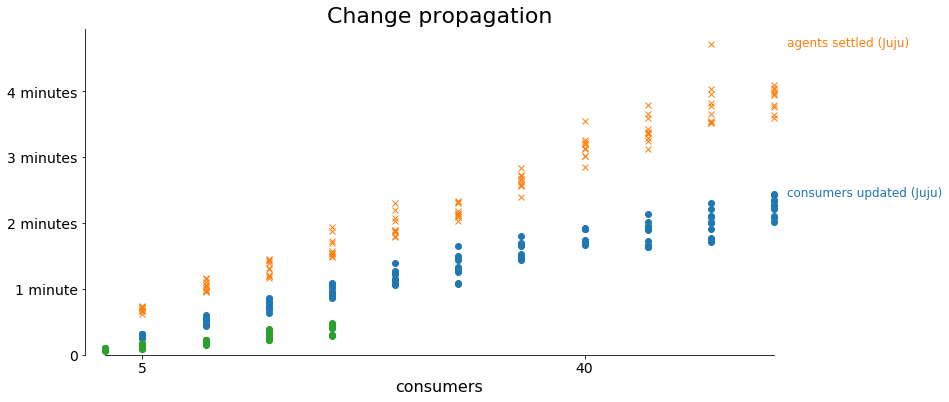

In [12]:
%matplotlib inline

changedatap_juju = juju_data[(juju_data["action"]=="change") & (juju_data['event'] == "pods")]
changedataj_juju = juju_data[(juju_data["action"]=="change") & (juju_data['event'] == "juju")]
deploydatap_juju = juju_data[(juju_data["action"]=="deploy") & (juju_data['event'] == "pods")]
deploydataj_juju = juju_data[(juju_data["action"]=="deploy") & (juju_data['event'] == "juju")]

changedata_k8s = k8s_data[(k8s_data["action"]=="change") & (k8s_data['event'] == "pods")]

def create_multiple_soy_clusters():
    (fig, ax) = create_sane_figure()

    ax.set_title("Change propagation", fontsize=22)
    ax.set_xlabel("consumers")
#     ax.set_xticks(range(0, 50, 5))
    ax.set_xticks([5, 40])
    ax.set_yticks(np.arange(0, 5, 1))
    ax.set_yticklabels(["0", "1 minute", "2 minutes", "3 minutes", "4 minutes"])

    pods_juju_plot = ax.plot(
        changedatap_juju['num_consumers'], changedatap_juju['elapsed']/60,'o',
        clip_on=False,
    )
    agents_plot = ax.plot(
        changedataj_juju['num_consumers'], changedataj_juju['elapsed']/60,'x',
        clip_on=False,
    )
    pods_k8s_plot = ax.plot(
        changedata_k8s['num_consumers'], changedata_k8s['elapsed']/60,'o',
        clip_on=False,
    )
    
#     pods_k8s = ax.plot(
#         changedataj['num_consumers'], changedataj['elapsed']/60,'x',
#         clip_on=False,
#     )
    
    
    xs = []
    [xs.extend(l.get_xdata()) for l in ax.lines]
    xmax = max(xs)
    xmin = min(xs)
    
    plt.text(xmax+1, max(changedatap_juju['elapsed'])/60-0.03, 'consumers updated (Juju)', fontsize=12, color=pods_juju_plot[0].get_color())
    plt.text(xmax+1, max(changedataj_juju['elapsed'])/60-0.03, 'agents settled (Juju)', fontsize=12, color=agents_plot[0].get_color())
    
    
    ax.set_xlim(left=xmin, right=xmax)
    ax.set_ylim(bottom=0)
    ax.spines['left'].set_position(('outward', 20))

    # Save the plot to a file
    # fig.savefig("multiple_soy_clusters.png", bbox_inches="tight")
#     fig.savefig("multiple_soy_clusters.tiff", bbox_inches="tight", dpi=300)
    fig.show()
create_multiple_soy_clusters()

In [10]:
data


grouped = data.groupby(
    ["num_consumers", "action", 'event']
).agg(
    {'elapsed':['mean','std']}
)


grouped.head()


elapsed          
                                 mean       std
num_consumers action event                     
5             change juju   41.333786  2.260088
                     pods   17.347727  1.515150
              deploy juju   77.424011       NaN
                     pods   71.297592       NaN
10            change juju   62.522602  4.723651

In [3]:
merged = grouped.unstack(0)
merged.columns = merged.columns.swaplevel(2, 1)
merged.sort_index(level=0, axis='columns', inplace=True)
merged.columns.set_levels(['unary','binary'],level=1, inplace=True)
merged.head()
final = merged.reset_index()
final.columns = ['agents', 'unary_mean', 'unary_std', 'binary_mean', 'binary_std']

final.head()

,agents,unary_mean,unary_std,binary_mean,binary_std
0,10,0.164732,0.039519,0.068583,0.012888
1,20,0.231848,0.066786,0.099073,0.003903
2,30,0.348394,0.026522,0.165894,0.023393
3,40,0.676056,0.040610,0.247531,0.025086
4,50,1.012338,0.041795,0.328656,0.009708


In [4]:
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt


def create_sane_figure():
    # You typically want your plot to be ~1.33x wider than tall.
    # Common sizes: (10, 7.5) and (12, 9)
    fig = plt.figure(figsize=(12, 6))  # a new figure window
    ax = fig.add_subplot(1, 1, 1)      # specify (nrows, ncols, axnum)

    # Put the axis behind the datapoints
    ax.set_axisbelow(True)
    # Grey ticks, labels, and axis'
    for spine in ax.spines.values():
        spine.set_color('black')
    for line in ax.get_xticklines() + ax.get_yticklines():
        line.set_color('black')
    ax.set_xlabel(None, fontsize=16, color='black')
    ax.set_ylabel(None, fontsize=16, color='black')
    # Don't show a grid
    ax.grid(False)
    # remove top and right border of graph
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(
        axis='both', which='both',
        labelsize=14, labelcolor='black',
        color='black')
    # Make the title big enough so it spans the entire plot, but don't make it
    # so big that it requires two lines to show.
    ax.set_title(None, fontsize=22, color='black')
    return (fig, ax)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


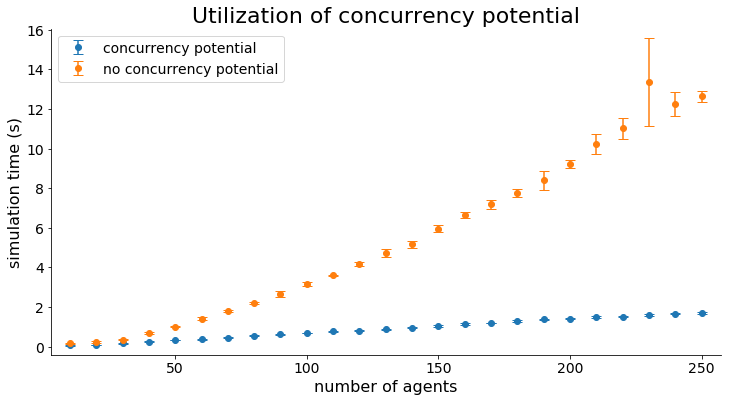

In [5]:
%matplotlib inline

def create_concurrency_potential_graph():
    (fig, ax) = create_sane_figure()

    ax.set_title("Utilization of concurrency potential", fontsize=22)
    ax.set_xlabel("number of agents")
    ax.set_ylabel("simulation time (s)")

    ax.set_xticks(range(0, 251, 50))
    ax.set_yticks(np.arange(0, 17, 2))

    # Now put the actual data in the plot
    ax.errorbar(
        final.agents, final.binary_mean,  # https://stackoverflow.com/a/21989204/1588555
        yerr=final.binary_std,
        label="concurrency potential",
        linestyle='None',
        capsize=5,
        fmt='o'
    )
    ax.errorbar(
        final.agents, final.unary_mean,  # https://stackoverflow.com/a/21989204/1588555
        yerr=final.unary_std,
        label="no concurrency potential",
        linestyle='None',
        capsize=5,
        fmt='o'
    )

    ax.legend()
    ax.legend(loc=2, prop={'size': 14})

    
    ax.margins(0.03)
    # Save the plot to a file
    fig.savefig("concurrency_potential.tiff", bbox_inches="tight", dpi=300)
    fig.show()
create_concurrency_potential_graph()